In [3]:
import os
import pandas as pd

# Definir la ruta base del dataset
base_path = '/home/canveo/carla_ws/dataseg_1'  # Cambia esto a la ruta real de tu dataset

# Crear una lista para almacenar los DataFrames individuales
dataframes = []

# Iterar sobre cada carpeta en el dataset
for i in range(1, 7):
    folder_name = f"dataset_{i}"
    folder_path = os.path.join(base_path, folder_name)
    csv_path = os.path.join(folder_path, "labels.csv")
    
    if os.path.exists(csv_path):
        # Leer el archivo CSV en un DataFrame
        df = pd.read_csv(csv_path)
        
        # Filtrar las columnas necesarias
        df = df[["image_rgb_name", "image_seg_name", "label"]]
        
        # Agregar la ruta completa a la columna "image_name"
        df["image_rgb_name"] = df["image_rgb_name"].apply(lambda x: f"{folder_name}/imageRGB/{x}")
        df["image_seg_name"] = df["image_seg_name"].apply(lambda x: f"{folder_name}/imageSEG/{x}")
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
final_df = pd.concat(dataframes, ignore_index=True)

# Mostrar los primeros registros del DataFrame final
print(final_df.head())

# Guardar el DataFrame final en un archivo CSV si es necesario
# final_df.to_csv(os.path.join(base_path, "combined_data.csv"), index=False)

                          image_rgb_name  \
0  dataset_1/imageRGB/frame_2038_rgb.png   
1  dataset_1/imageRGB/frame_2086_rgb.png   
2  dataset_1/imageRGB/frame_2160_rgb.png   
3  dataset_1/imageRGB/frame_2193_rgb.png   
4  dataset_1/imageRGB/frame_2236_rgb.png   

                          image_seg_name  label  
0  dataset_1/imageSEG/frame_2038_seg.png  recto  
1  dataset_1/imageSEG/frame_2086_seg.png  recto  
2  dataset_1/imageSEG/frame_2160_seg.png  recto  
3  dataset_1/imageSEG/frame_2193_seg.png  recto  
4  dataset_1/imageSEG/frame_2236_seg.png  recto  


In [4]:
class_counts = final_df['label'].value_counts()
print("Distribución de clases antes del balanceo:")
print(class_counts)

Distribución de clases antes del balanceo:
label
recto    48223
curvo    18978
Name: count, dtype: int64


In [5]:
minority_class_count = class_counts.min()

# Crear un DataFrame balanceado tomando muestras aleatorias
balanced_df = pd.concat([
    final_df[final_df['label'] == label].sample(minority_class_count, random_state=42)
    for label in class_counts.index
], ignore_index=True)

# Mostrar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(balanced_df['label'].value_counts())

# Guardar el DataFrame balanceado en un archivo CSV si es necesario
balanced_df.to_csv(os.path.join(base_path, "combined_data_balanced.csv"), index=False)

# Mostrar los primeros registros del DataFrame balanceado
print(balanced_df.head())

Distribución de clases después del balanceo:
label
recto    18978
curvo    18978
Name: count, dtype: int64
                            image_rgb_name  \
0  dataset_1/imageRGB/frame_478336_rgb.png   
1  dataset_2/imageRGB/frame_488708_rgb.png   
2  dataset_6/imageRGB/frame_464772_rgb.png   
3  dataset_4/imageRGB/frame_559602_rgb.png   
4  dataset_5/imageRGB/frame_288530_rgb.png   

                            image_seg_name  label  
0  dataset_1/imageSEG/frame_478336_seg.png  recto  
1  dataset_2/imageSEG/frame_488708_seg.png  recto  
2  dataset_6/imageSEG/frame_464772_seg.png  recto  
3  dataset_4/imageSEG/frame_559602_seg.png  recto  
4  dataset_5/imageSEG/frame_288530_seg.png  recto  


In [6]:
# data_loader.py

import tensorflow as tf
import pandas as pd
import numpy as np
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import os

# Verificar si TensorFlow detecta la GPU
print("GPUs detectadas:", tf.config.list_physical_devices('GPU'))

# Configuración para que TensorFlow use solo la GPU y limite el uso de memoria
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No se detectó ninguna GPU. Asegúrate de que los drivers y CUDA/cuDNN estén correctamente instalados.")

# Transformaciones de imagen usando Albumentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    A.GaussianBlur(p=0.2),
    A.MotionBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset personalizado para cargar imágenes y etiquetas
class CurvatureDataset(Sequence):
    def __init__(self, dataframe, base_dir, transform=None, batch_size=64, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Llamada a la clase base con los argumentos adicionales
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.dataframe) // self.batch_size
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images, batch_labels = [], []

        for i in batch_indices:
            image_rgb_name = self.dataframe.iloc[i]['image_rgb_name']
            label = self.dataframe.iloc[i]['label']

            # Convertir la etiqueta a valor numérico
            label = 0 if label == 'recto' else 1

            # Cargar la imagen RGB
            image_rgb_path = os.path.join(self.base_dir, image_rgb_name)
            image_rgb = Image.open(image_rgb_path).convert("RGB")
            image_rgb = np.array(image_rgb)

            # Aplicar las transformaciones si es necesario
            if self.transform:
                transformed = self.transform(image=image_rgb)
                image_rgb = transformed["image"]

            batch_images.append(image_rgb)
            batch_labels.append(label)
        
        batch_images = np.array(batch_images, dtype="float32")
        batch_labels = np.array(batch_labels, dtype="int32")

        return batch_images, tf.convert_to_tensor(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Cargar el DataFrame
balanced_df = pd.read_csv('/home/canveo/carla_ws/dataseg_1/combined_data_balanced.csv')

# Dividir en entrenamiento y validación
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Crear datasets de entrenamiento y validación
train_dataset = CurvatureDataset(dataframe=train_df, base_dir='/home/canveo/carla_ws/dataseg_1', transform=train_transform, batch_size=64, shuffle=True)
val_dataset = CurvatureDataset(dataframe=val_df, base_dir='/home/canveo/carla_ws/dataseg_1', transform=val_transform, batch_size=64, shuffle=False)


/home/canveo/venv/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


In [5]:
# import timm

# # Crear el modelo EfficientNet preentrenado
# model = timm.create_model('efficientnet_b0', pretrained=True)  # Puedes cambiar a otros modelos EfficientNet
# num_ftrs = model.get_classifier().in_features  # Obtener el número de características de la última capa

# for param in model.parameters():
#     param.requires_grad = False  # Congelar todas las capas

# # Solo descongelar la última capa
# for param in model.classifier.parameters():
#     param.requires_grad = True


# # Reemplazar la capa de clasificación para adaptarla a nuestra tarea (2 clases: recto y curvo)
# model.classifier = nn.Linear(num_ftrs, 2)  # 2 clases: recto (0) y curvo (1)

# # Mover el modelo al dispositivo (GPU si está disponible)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Definir la función de pérdida y el optimizador
# criterion = nn.CrossEntropyLoss()  # Para clasificación binaria
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Ajusta el learning rate si es necesario
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import timm
# from torch.utils.tensorboard import SummaryWriter

# # Inicializar el modelo EfficientNet_B0
# class EfficientNetWithDropout(nn.Module):
#     def __init__(self, dropout_rate=0.3):
#         super(EfficientNetWithDropout, self).__init__()
#         self.base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
#         self.dropout = nn.Dropout(p=dropout_rate)  # Dropout con tasa 30%
    
#     def forward(self, x):
#         x = self.base_model.forward_features(x)
#         x = self.dropout(x)
#         x = self.base_model.classifier(x)  # Forward hacia la capa de clasificación
#         return x

# # Crear una instancia del modelo con Dropout
# model = EfficientNetWithDropout(dropout_rate=0.3)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Definir la función de pérdida y el optimizador
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [6]:
# train_model.py

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0


# Crear un modelo EfficientNetB0 con Dropout
def create_model(dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = True  # Ajustar a True si deseas entrenar toda la red

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(2, activation='softmax')  # 2 clases
    ])
    
    return model

# Crear una instancia del modelo
model = create_model(dropout_rate=0.3)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configuración de TensorBoard
tensorboard_callback = callbacks.TensorBoard(log_dir='logs/efficientnet_b0_with_dropout')

# Early Stopping
early_stopping_callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Entrenamiento del modelo
num_epochs = 100

# Entrenar el modelo usando `train_dataset` y `val_dataset`
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

# Guardar el mejor modelo
model.save('best_efficientnet_model_with_dropout.h5')


I0000 00:00:1731507571.074147    3645 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731507571.074379    3645 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731507571.074482    3645 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731507571.133750    3645 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/100


I0000 00:00:1731507594.058168    3795 service.cc:146] XLA service 0x782f6c00a840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731507594.058206    3795 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-13 09:19:54.621492: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 09:19:56.773444: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
E0000 00:00:1731507617.751215    3795 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731507617.842589    3795 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsigh

474/474 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.7232 - loss: 0.5307

2024-11-13 09:26:08.662316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2048', 20 bytes spill stores, 20 bytes spill loads

2024-11-13 09:26:08.727022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2048', 248 bytes spill stores, 248 bytes spill loads



474/474 ━━━━━━━━━━━━━━━━━━━━ 472s 860ms/step - accuracy: 0.7234 - loss: 0.5305 - val_accuracy: 0.8505 - val_loss: 0.3596
Epoch 2/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 390s 813ms/step - accuracy: 0.8950 - loss: 0.2619 - val_accuracy: 0.9558 - val_loss: 0.1234
Epoch 3/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 402s 837ms/step - accuracy: 0.9282 - loss: 0.1820 - val_accuracy: 0.9669 - val_loss: 0.0870
Epoch 4/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 400s 833ms/step - accuracy: 0.9421 - loss: 0.1492 - val_accuracy: 0.9744 - val_loss: 0.0690
Epoch 5/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 393s 820ms/step - accuracy: 0.9529 - loss: 0.1215 - val_accuracy: 0.9723 - val_loss: 0.0729
Epoch 6/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 389s 811ms/step - accuracy: 0.9584 - loss: 0.1032 - val_accuracy: 0.9766 - val_loss: 0.0671
Epoch 7/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 389s 812ms/step - accuracy: 0.9630 - loss: 0.0949 - val_accuracy: 0.9788 - val_loss: 0.0565
Epoch 8/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 401s 837ms/step - accuracy: 0.9686 - los

In [7]:
# Guardar el modelo en formato HDF5
model.save('efficientnet_model_with_dropout.h5')

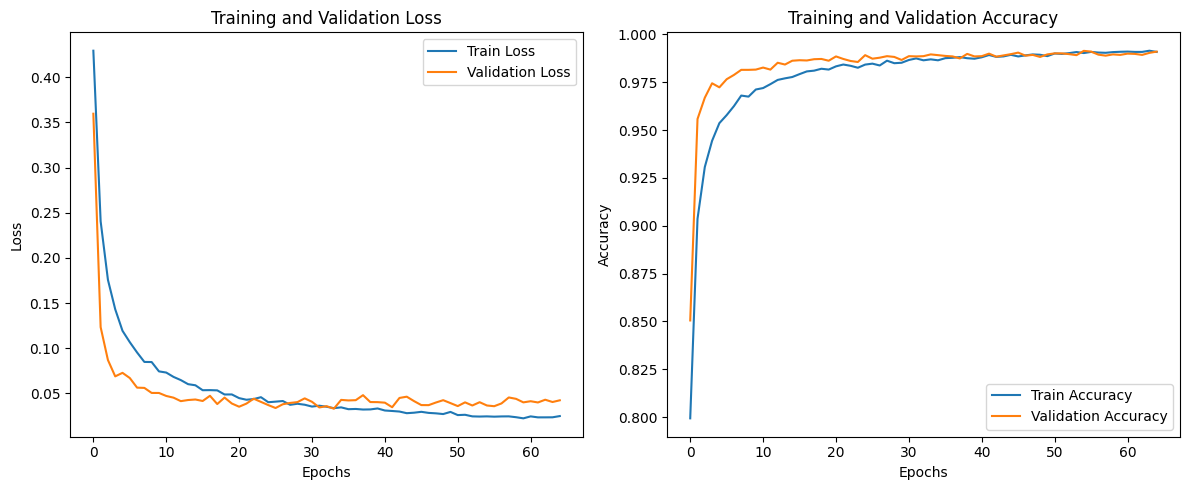

In [8]:
import matplotlib.pyplot as plt

# Extraer métricas del historial de entrenamiento
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Guardar el modelo en formato HDF5
model.save('efficientnet_model_with_dropout_2.h5')
model.save('efficientnet_model_with_dropout_2.keras')

In [1]:
# Reconstruir el modelo funcionalmente
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def create_model(dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = True

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Crear la arquitectura y cargar los pesos
model = create_model(dropout_rate=0.3)
model.load_weights('best_efficientnet_model_with_dropout.h5') 

2024-11-15 07:33:04.366514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 07:33:04.552942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 07:33:04.636961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 07:33:04.670294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 07:33:04.809869: I tensorflow/core/platform/cpu_feature_guar

I0000 00:00:1731674116.319628    5693 service.cc:146] XLA service 0x77dca4046590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731674116.319675    5693 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-15 07:35:16.425454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 07:35:16.956264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


I0000 00:00:1731674122.773632    5693 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


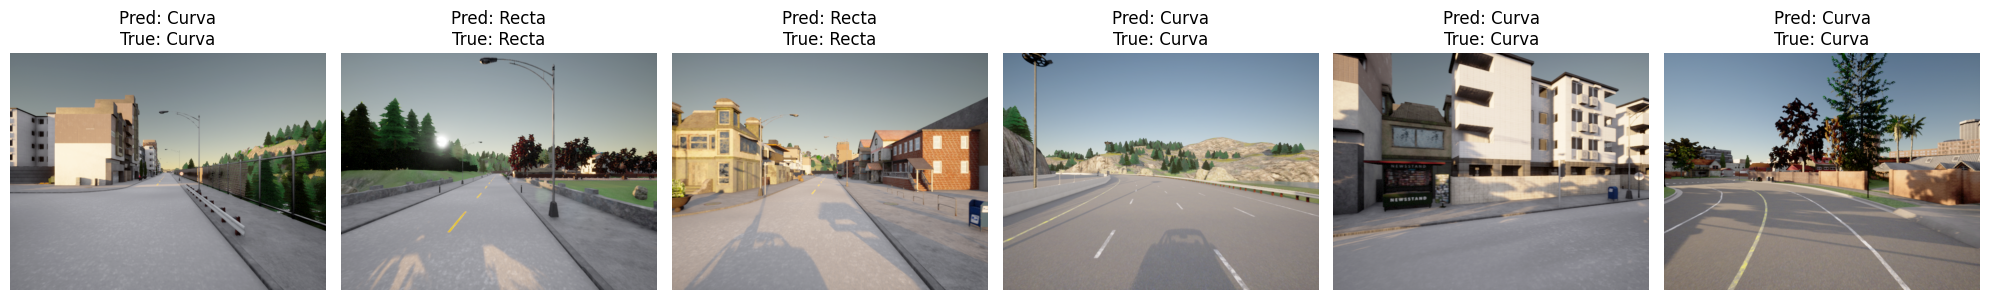

In [9]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd
import os

# Reconstruir y cargar el modelo con los pesos
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def create_model(dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = True

    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model(dropout_rate=0.3)
model.load_weights('best_efficientnet_model_with_dropout.h5')  # Cargar los pesos

# Transformación de preprocesamiento
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalizar entre 0 y 1
    img_array = (img_array - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # Normalización
    return np.expand_dims(img_array, axis=0)

# Seleccionar aleatoriamente algunas imágenes del conjunto de validación
num_images_to_test = 6
random_indices = random.sample(range(len(val_df)), k=num_images_to_test)

# Realizar inferencia y mostrar los resultados
fig, axes = plt.subplots(1, num_images_to_test, figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # Obtener el nombre de la imagen y la etiqueta
    img_path = os.path.join('/home/canveo/carla_ws/dataseg_1', val_df.iloc[idx]['image_rgb_name'])
    true_label = val_df.iloc[idx]['label']

    # Preprocesar la imagen
    input_tensor = preprocess_image(img_path)

    # Inferencia
    prediction = model.predict(input_tensor)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Decodificar la predicción
    predicted_label = 'Recta' if predicted_class == 0 else 'Curva'
    true_label_str = 'Recta' if true_label == 'recto' else 'Curva'

    # Mostrar la imagen junto con las etiquetas de predicción y reales
    img = load_img(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Pred: {predicted_label}\nTrue: {true_label_str}', fontsize=12)

plt.tight_layout()
plt.show()


In [2]:
from tensorflow.keras.models import load_model

model = load_model("best_efficientnet_model_with_dropout.h5")
model.save('/model', save_format='tf')


2024-11-14 15:11:06.585852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 15:11:06.595048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 15:11:06.606043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 15:11:06.609335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 15:11:06.617975: I tensorflow/core/platform/cpu_feature_guar

ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_511>, <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_512>]